In [1]:
import pandas as pd
import numpy as np

In [11]:
!pip3 install neo4j
! pip3 install neo4jrestclient
!pip3 install py2neo


    100% |████████████████████████████████| 184kB 2.0MB/s ta 0:00:01
  Stored in directory: /Users/alena/Library/Caches/pip/wheels/5f/36/4c/bde6e0d19509f6e3697caaf5a2d82039552602d114e1710a7b
  Stored in directory: /Users/alena/Library/Caches/pip/wheels/8e/51/2b/623ff6538b9f4bc9368d568a5873b765f1178fe9af807d1296
  Stored in directory: /Users/alena/Library/Caches/pip/wheels/d4/b4/c4/ab867cd0ac9e667f8cd269f9364fd1cb8ee75fe50f5ce97c79
Successfully built neo4j neobolt neotime


In [1]:
from neo4jrestclient.client import GraphDatabase

### Загрузим данные через вк апи и запишем граф в файл

In [31]:
import vk_api
vk_session = vk_api.VkApi('guzharina.alena@gmail.com', 'AlenaGuzharina1')
vk_session.auth()
vk = vk_session.get_api()

In [32]:
my_friends_info = vk.friends.get(fields = ['first_name','last_name','city', 'university_name','deactivated','is_closed'])['items']

In [33]:
my_friends_info_clean = []
deactivated_list = []
for friend in my_friends_info:
    if ('deactivated' not in friend):
        if friend['is_closed'] == False:
            my_friends_info_clean.append(friend)
        else:
            deactivated_list.append(friend)
    else: 
        deactivated_list.append(friend)


In [34]:
my_friends_list = [str(d['id']) for d in my_friends_info_clean]
vertex = my_friends_list

In [35]:
len(deactivated_list)

149

In [36]:
len(my_friends_info_clean)

663

In [37]:
my_friends_names = pd.DataFrame(columns=['id','name'])
for friend in my_friends_info_clean:
    temp = pd.DataFrame({'id':friend['id'],'name':friend['last_name']+' '+friend['first_name']},index=[0])
    my_friends_names = my_friends_names.append(temp,ignore_index=True)

In [38]:
my_friends_names
my_friends_names.to_csv('my_friends_names.csv',index=False)

In [39]:
len(my_friends_list)==len(my_friends_names)

True

In [45]:
edges = pd.DataFrame(columns =['source','target'])
for friend in my_friends_list:
    mut = vk.friends.getMutual(target_uid = friend)
    for mutual in mut:
        if (mutual not in deactivated_list):
            temp = pd.DataFrame({'source':friend,'target': mutual},index=[0])
            edges = edges.append(temp,ignore_index= True)
edges.to_csv('edges.csv',index=False,header=False)

__Итого у нас два файла: файл с именами и айдишниками и файл связей - дружбы между друзьями__

### Матрица сопряженности

In [46]:
import networkx as nx
G = nx.read_edgelist("edges.csv", delimiter=',',create_using = nx.Graph(), nodetype=str)
A = nx.adjacency_matrix(G)

In [47]:
print(A)

  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 6)	1
  (0, 7)	1
  (0, 8)	1
  (0, 9)	1
  (0, 10)	1
  (0, 11)	1
  (0, 12)	1
  (0, 13)	1
  (0, 14)	1
  (0, 15)	1
  (0, 16)	1
  (0, 17)	1
  (0, 18)	1
  (0, 19)	1
  (0, 20)	1
  (0, 21)	1
  (0, 22)	1
  (0, 23)	1
  (0, 24)	1
  (0, 25)	1
  :	:
  (745, 728)	1
  (746, 740)	1
  (747, 435)	1
  (748, 740)	1
  (749, 363)	1
  (749, 676)	1
  (750, 199)	1
  (751, 695)	1
  (752, 569)	1
  (752, 753)	1
  (753, 752)	1
  (754, 87)	1
  (755, 570)	1
  (756, 757)	1
  (757, 148)	1
  (757, 408)	1
  (757, 471)	1
  (757, 756)	1
  (758, 92)	1
  (758, 314)	1
  (759, 502)	1
  (760, 21)	1
  (761, 534)	1
  (762, 293)	1
  (763, 474)	1


### Теперь зальем все в neo4j DBMS и посмотрим на датасет. 

In [7]:
db = GraphDatabase(url="http://localhost:7474",username="neo4j", password="1234567890")

In [8]:
import pandas as pd
my_friends_names = pd.read_csv('my_friends_names.csv',)
edges = pd.read_csv('edges.csv')

In [9]:
names_dict = {}
for row in my_friends_names.values:
    names_dict[row[0]]=row[1]

In [10]:
list_of_n = []
for el in names_dict:
    node = db.nodes.create(name=names_dict[el], user_id=el)
    list_of_n.append(node)

In [11]:
from neo4jrestclient.query import Q

In [ ]:
names_dict[320571]

In [12]:
for el in edges.values:
    try:
        lookup = Q('user_id', equals=int(el[1]))
        n2 = db.nodes.filter(lookup)[0]
        try:
            lookup = Q('user_id', equals=int(el[0]))
            n1 = db.nodes.filter(lookup)[0]
            n1.relationships.create("Knows", n2)
        except:
            print('no such id')
            print(int(el[0]))
    except:
        print('no such id')
        print(int(el[1]))

no such id
11811054
no such id
34364621
no such id
58467936
no such id
77832132
no such id
207017346
no such id
246034870
no such id
384408513
no such id
450631188
no such id
34364621
no such id
384408513
no such id
410741874
no such id
11811054
no such id
12479049
no such id
15571860
no such id
20957994
no such id
21282361
no such id
71789576
no such id
14464179
no such id
23026502
no such id
296176673
no such id
2175134
no such id
43667660
no such id
347402225
no such id
119315648
no such id
11811054
no such id
12479049
no such id
34364621
no such id
58467936
no such id
90060453
no such id
207017346
no such id
338508275
no such id
96633466
no such id
450631188
no such id
11756480
no such id
11811054
no such id
58467936
no such id
296176673
no such id
46219176
no such id
384408513
no such id
384408513
no such id
11756480
no such id
58467936
no such id
338508275
no such id
12479049
no such id
34937420
no such id
39530954
no such id
47269380
no such id
58261105
no such id
60389014
no su

no such id
22834988
no such id
23026502
no such id
165523257
no such id
296176673
no such id
11811054
no such id
15571860
no such id
29393394
no such id
15571860
no such id
20957994
no such id
21282361
no such id
29393394
no such id
71789576
no such id
132881942
no such id
296176673
no such id
8057526
no such id
10652646
no such id
15571860
no such id
16906141
no such id
17187483
no such id
18386920
no such id
23026502
no such id
25444297
no such id
27082227
no such id
29488442
no such id
29737795
no such id
30394747
no such id
34015040
no such id
39047593
no such id
39530954
no such id
50895221
no such id
58467936
no such id
60389014
no such id
67543936
no such id
70730397
no such id
75732986
no such id
84994638
no such id
132881942
no such id
142192240
no such id
150590876
no such id
165523257
no such id
175502278
no such id
270340203
no such id
296176673
no such id
17187483
no such id
22834988
no such id
29488442
no such id
84994638
no such id
165523257
no such id
270340203
no such 

no such id
60389014
no such id
67543936
no such id
20957994
no such id
30394747
no such id
34015040
no such id
42225349
no such id
60389014
no such id
70730397
no such id
165523257
no such id
175502278
no such id
39116797
no such id
86061565
no such id
151661225
no such id
216257740
no such id
8057526
no such id
11756480
no such id
90060453
no such id
270340203
no such id
296176673
no such id
450631188
no such id
8351348
no such id
20957994
no such id
21282361
no such id
29488442
no such id
42225349
no such id
60389014
no such id
67543936
no such id
68082754
no such id
71789576
no such id
175502278
no such id
34937420
no such id
40534258
no such id
47269380
no such id
52518285
no such id
58261105
no such id
142192240
no such id
29488442
no such id
34015040
no such id
39047593
no such id
60389014
no such id
70730397
no such id
140581379
no such id
163697968
no such id
165523257
no such id
175502278
no such id
204260313
no such id
11756480
no such id
73272456
no such id
139524433
no such

no such id
50338765
no such id
55191367
no such id
59662268
no such id
63166116
no such id
101512346
no such id
296486429
no such id
27082227
no such id
29488442
no such id
84994638
no such id
15571860
no such id
18386920
no such id
23026502
no such id
30394747
no such id
70730397
no such id
75732986
no such id
270340203
no such id
296176673
no such id
34937420
no such id
60389014
no such id
70730397
no such id
175502278
no such id
40178363
no such id
15571860
no such id
34364621
no such id
46219176
no such id
384408513
no such id
8351348
no such id
77832132
no such id
140581379
no such id
163697968
no such id
165523257
no such id
70730397
no such id
84994638
no such id
16906141
no such id
48177433
no such id
51750839
no such id
55191367
no such id
63166116
no such id
70730397
no such id
101512346
no such id
296176673
no such id
79336746
no such id
450631188
no such id
8057526
no such id
16906141
no such id
23026502
no such id
25444297
no such id
34015040
no such id
34816833
no such id

no such id
119315648
no such id
142192240
no such id
178927116
no such id
182316760
no such id
15571860
no such id
18386920
no such id
22700387
no such id
23026502
no such id
29488442
no such id
34015040
no such id
47269380
no such id
48177433
no such id
59662268
no such id
60389014
no such id
67543936
no such id
70730397
no such id
142994713
no such id
150590876
no such id
151505042
no such id
165523257
no such id
181905872
no such id
22700387
no such id
50338765
no such id
59662268
no such id
70730397
no such id
101512346
no such id
34937420
no such id
40534258
no such id
47269380
no such id
119315648
no such id
139524433
no such id
142192240
no such id
8351348
no such id
16906141
no such id
20957994
no such id
29488442
no such id
39530954
no such id
50895221
no such id
58918227
no such id
60389014
no such id
67543936
no such id
84994638
no such id
163697968
no such id
165523257
no such id
175502278
no such id
204260313
no such id
11811054
no such id
34364621
no such id
46219176
no s

no such id
34937420
no such id
47269380
no such id
50681116
no such id
119315648
no such id
142192240
no such id
182316760
no such id
8351348
no such id
10652646
no such id
29488442
no such id
39047593
no such id
39530954
no such id
50895221
no such id
163697968
no such id
165523257
no such id
175502278
no such id
58918227
no such id
67543936
no such id
119315648
no such id
11811054
no such id
34364621
no such id
46219176
no such id
58467936
no such id
338508275
no such id
34585991
no such id
39116797
no such id
91471404
no such id
151661225
no such id
8057526
no such id
39530954
no such id
70730397
no such id
132881942
no such id
165523257
no such id
447231692
no such id
12479049
no such id
15571860
no such id
16906141
no such id
17187483
no such id
18386920
no such id
22834988
no such id
23026502
no such id
25444297
no such id
30394747
no such id
58918227
no such id
70730397
no such id
75732986
no such id
82575299
no such id
138456669
no such id
150590876
no such id
165523257
no such

no such id
29488442
no such id
40534258
no such id
58918227
no such id
84994638
no such id
150590876
no such id
165523257
no such id
270340203
no such id
296176673
no such id
58918227
no such id
34937420
no such id
47269380
no such id
58261105
no such id
175502278
no such id
22834988
no such id
23026502
no such id
70730397
no such id
73272456
no such id
150590876
no such id
270340203
no such id
296176673
no such id
8057526
no such id
15571860
no such id
17187483
no such id
18386920
no such id
20957994
no such id
21282361
no such id
23026502
no such id
29393394
no such id
30394747
no such id
34015040
no such id
34816833
no such id
58918227
no such id
63166116
no such id
70730397
no such id
71789576
no such id
84182125
no such id
150590876
no such id
151632755
no such id
204260313
no such id
270340203
no such id
296176673
no such id
15571860
no such id
22834988
no such id
23026502
no such id
30394747
no such id
150590876
no such id
247201224
no such id
285028809
no such id
16906141
no su

### Итого у нас людей и связей

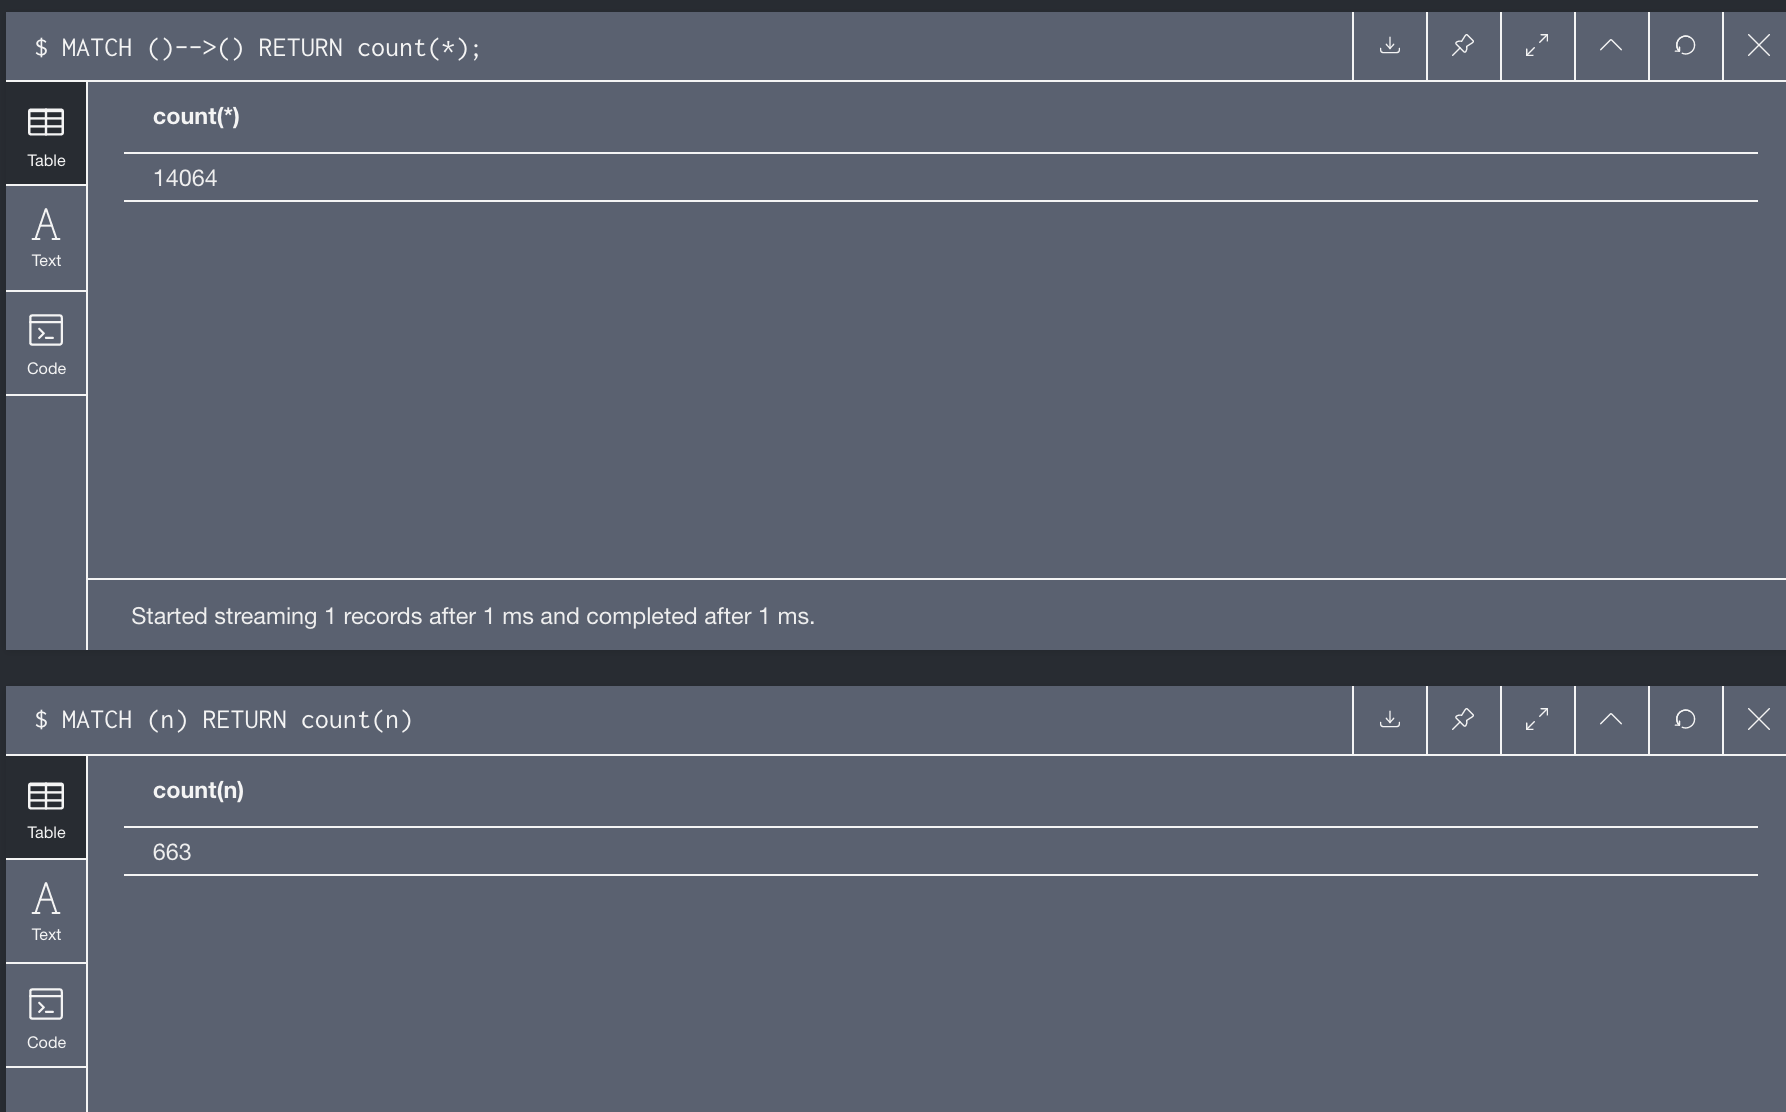

### Пример как это выглядит

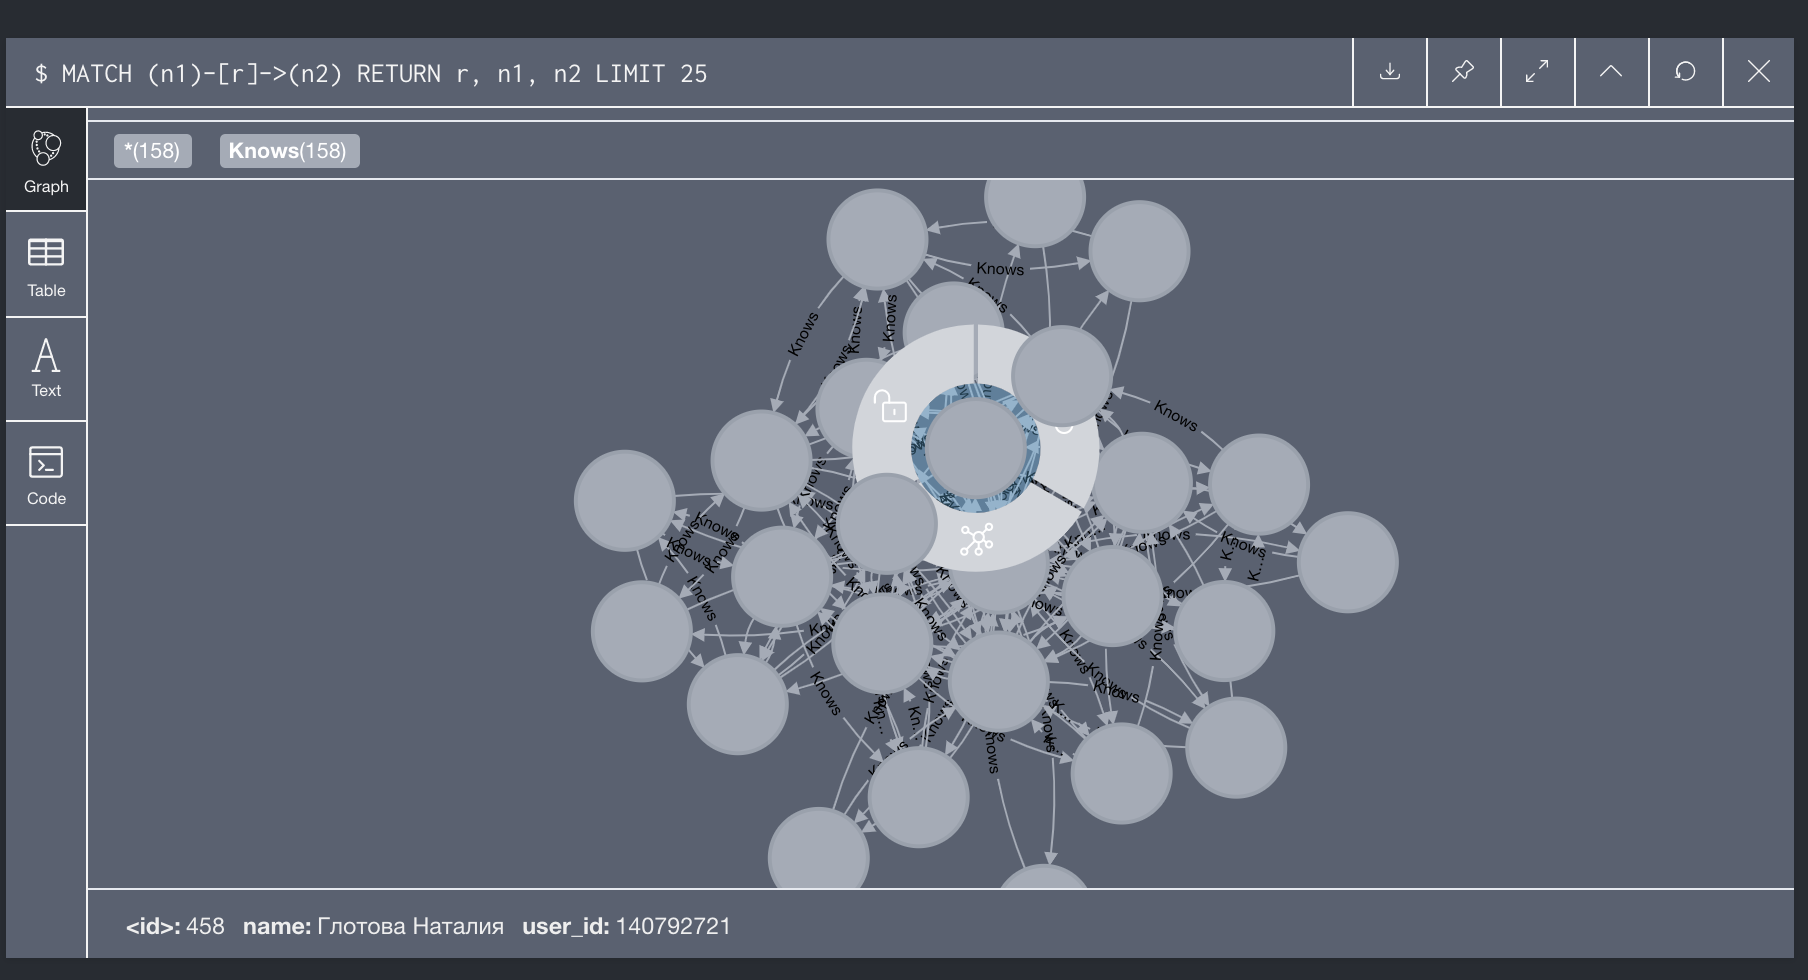